In [16]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve, auc

In [19]:
df = pd.read_csv(r"C:\Users\nicol\Desktop\git\df_pca.csv", index_col=0)
df = df.reset_index()

In [20]:
# First predictors: progressive number of points for each team for each championship

df['pp'] = 0

for index, row in df.iterrows():
    if row['round'] == 1:
        df.at[index, 'pp'] = 0
    else:
        if row['round'] > 1:  # Check if 'round' value is greater than 1
            # Calculate pp based on the specified criteria
            prev_row = df.iloc[index - 1]

            if prev_row['result'] == 'W':
                df.at[index, 'pp'] = 3 + prev_row['pp']
            elif prev_row['result'] == 'D':
                df.at[index, 'pp'] = 1 + prev_row['pp']
            elif prev_row['result'] == 'L':
                df.at[index, 'pp'] = prev_row['pp']

df


,team,Unnamed: 1,date,time,round,day,venue,result,gf,ga,...,nCen,nAtt,rate,new_1,new_2,new_3,new_4,new_5,new_6,pp
0,Atalanta,0,2021-08-21,20:45,1.0,Sat,Away,W,2.0,1.0,...,4,3,80,1.042486,-4.272156,-1.803107,-1.921861,2.269445,-0.099223,0
1,Atalanta,1,2021-08-28,18:30,2.0,Sat,Home,D,0.0,0.0,...,4,3,80,-2.760177,3.275253,-0.512572,-1.675064,-0.880966,2.373064,3
2,Atalanta,2,2021-09-11,20:45,3.0,Sat,Home,L,1.0,2.0,...,4,3,80,-0.858845,-0.498451,-1.157839,-1.798462,0.694240,1.136920,4
3,Atalanta,3,2021-09-18,20:45,4.0,Sat,Away,W,1.0,0.0,...,4,3,80,-1.628427,-0.324883,-1.133534,-1.353323,-0.007089,-0.124862,4
4,Atalanta,4,2021-09-21,20:45,5.0,Tue,Home,W,2.0,1.0,...,4,3,80,-2.371464,1.101452,-1.213016,-0.970753,-0.928484,-0.106655,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,Venezia,33,2022-05-01,12:30,35.0,Sun,Away,L,1.0,2.0,...,4,3,72,-0.031293,0.428894,-0.451508,-0.175167,-0.033984,-1.044184,22
1916,Venezia,34,2022-05-05,18:00,20.0,Thu,Away,L,1.0,2.0,...,4,3,72,0.253164,0.520844,0.548098,0.555945,-0.969628,-1.108095,22
1917,Venezia,35,2022-05-08,15:00,36.0,Sun,Home,W,4.0,3.0,...,4,3,72,-0.093164,0.447422,0.366812,1.259560,-0.065459,-0.054158,22
1918,Venezia,36,2022-05-14,20:45,37.0,Sat,Away,D,1.0,1.0,...,3,2,72,0.870685,-0.422997,-0.003344,1.149430,-0.131722,1.290195,25


In [22]:
## Second predictors (WDL):  index telling me how many points have
## been scored in the last 3 games for each team

## 
def calculate_WDL(group):
    
    group['WDL'] = group['result'].map({'W': 3, 'L': 0, 'D': 1}).shift(1).rolling(3, min_periods=1).sum()
    
    round_condition = (group['round'] == 1)
    
    group['WDL'] = group['WDL'].where(~ round_condition, 0)
    
    
    return group

df = df.groupby('team', as_index = True).apply(calculate_WDL).fillna(0)
df.reset_index(level='team', drop=True, inplace=True)

## checking 

atalanta_df = df[df['team'] == 'Atalanta'] 
atalanta_df.head(60)

,team,Unnamed: 1,date,time,round,day,venue,result,gf,ga,...,nAtt,rate,new_1,new_2,new_3,new_4,new_5,new_6,pp,WDL
0,Atalanta,0,2021-08-21,20:45,1.0,Sat,Away,W,2.0,1.0,...,3,80,1.042486,-4.272156,-1.803107,-1.921861,2.269445,-0.099223,0,0.0
1,Atalanta,1,2021-08-28,18:30,2.0,Sat,Home,D,0.0,0.0,...,3,80,-2.760177,3.275253,-0.512572,-1.675064,-0.880966,2.373064,3,3.0
2,Atalanta,2,2021-09-11,20:45,3.0,Sat,Home,L,1.0,2.0,...,3,80,-0.858845,-0.498451,-1.157839,-1.798462,0.694240,1.136920,4,4.0
3,Atalanta,3,2021-09-18,20:45,4.0,Sat,Away,W,1.0,0.0,...,3,80,-1.628427,-0.324883,-1.133534,-1.353323,-0.007089,-0.124862,4,4.0
4,Atalanta,4,2021-09-21,20:45,5.0,Tue,Home,W,2.0,1.0,...,3,80,-2.371464,1.101452,-1.213016,-0.970753,-0.928484,-0.106655,7,4.0
5,Atalanta,5,2021-09-25,18:00,6.0,Sat,Away,D,2.0,2.0,...,3,80,-1.206751,-0.000168,-0.335959,0.161248,0.171606,-1.011174,10,6.0
6,Atalanta,6,2021-10-03,20:45,7.0,Sun,Home,L,2.0,3.0,...,3,80,-0.156011,0.181975,0.073675,0.527368,0.507983,-0.976223,11,7.0
7,Atalanta,7,2021-10-17,15:00,8.0,Sun,Away,W,4.0,1.0,...,3,80,-0.282466,0.205819,1.130137,0.698723,0.927609,-0.931937,11,4.0
8,Atalanta,8,2021-10-24,12:30,9.0,Sun,Home,D,1.0,1.0,...,3,80,-1.046927,0.329211,0.861100,-0.010766,-0.323056,-1.296365,14,4.0
9,Atalanta,9,2021-10-27,18:30,10.0,Wed,Away,W,3.0,1.0,...,3,80,-1.332419,-0.263917,1.226042,-0.710098,0.068371,-0.040161,15,4.0


In [23]:
# Third Predictor: average of expected goals for and expected goals against
#(xg_rolling) & (xga_rolling)

def rolling_averages(group, cols, new_cols):
    group = group.sort_values(by="date")
    window = min(len(group) - 1, 3)
    rolling_stats = group[cols].shift(1).rolling(window, min_periods=1).mean()
    
    # Set xg_rolling and xga_rolling to zero when round is 1
    round_condition = (group['round'] == 1)
    rolling_stats = rolling_stats.where(~round_condition, 0)
    
    # Assign rolling averages directly to new_cols
    group[new_cols] = rolling_stats
    
    return group

df = df.groupby('team').apply(rolling_averages, cols=['xg', 'xga'], new_cols=['xg_rolling', 'xga_rolling'])

## check 
df[['xg','xga', 'xg_rolling', 'xga_rolling']]

xg  xga  xg_rolling  xga_rolling
team                                            
Atalanta 0     0.7  1.3    0.000000     0.000000
         1     0.9  0.3    0.700000     1.300000
         2     2.2  1.8    0.800000     0.800000
         3     1.6  0.7    1.266667     1.133333
         4     1.9  0.9    1.566667     0.933333
...            ...  ...         ...          ...
Venezia  1915  0.6  1.6    0.733333     2.933333
         1916  1.1  2.1    0.533333     2.766667
         1917  2.8  2.6    0.866667     2.466667
         1918  0.3  2.7    1.500000     2.100000
         1919  1.0  1.9    1.400000     2.466667

[1920 rows x 4 columns]

In [24]:
df.reset_index(drop = True , inplace = True )
df

,team,Unnamed: 1,date,time,round,day,venue,result,gf,ga,...,new_1,new_2,new_3,new_4,new_5,new_6,pp,WDL,xg_rolling,xga_rolling
0,Atalanta,0,2021-08-21,20:45,1.0,Sat,Away,W,2.0,1.0,...,1.042486,-4.272156,-1.803107,-1.921861,2.269445,-0.099223,0,0.0,0.000000,0.000000
1,Atalanta,1,2021-08-28,18:30,2.0,Sat,Home,D,0.0,0.0,...,-2.760177,3.275253,-0.512572,-1.675064,-0.880966,2.373064,3,3.0,0.700000,1.300000
2,Atalanta,2,2021-09-11,20:45,3.0,Sat,Home,L,1.0,2.0,...,-0.858845,-0.498451,-1.157839,-1.798462,0.694240,1.136920,4,4.0,0.800000,0.800000
3,Atalanta,3,2021-09-18,20:45,4.0,Sat,Away,W,1.0,0.0,...,-1.628427,-0.324883,-1.133534,-1.353323,-0.007089,-0.124862,4,4.0,1.266667,1.133333
4,Atalanta,4,2021-09-21,20:45,5.0,Tue,Home,W,2.0,1.0,...,-2.371464,1.101452,-1.213016,-0.970753,-0.928484,-0.106655,7,4.0,1.566667,0.933333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,Venezia,33,2022-05-01,12:30,35.0,Sun,Away,L,1.0,2.0,...,-0.031293,0.428894,-0.451508,-0.175167,-0.033984,-1.044184,22,0.0,0.733333,2.933333
1916,Venezia,34,2022-05-05,18:00,20.0,Thu,Away,L,1.0,2.0,...,0.253164,0.520844,0.548098,0.555945,-0.969628,-1.108095,22,0.0,0.533333,2.766667
1917,Venezia,35,2022-05-08,15:00,36.0,Sun,Home,W,4.0,3.0,...,-0.093164,0.447422,0.366812,1.259560,-0.065459,-0.054158,22,0.0,0.866667,2.466667
1918,Venezia,36,2022-05-14,20:45,37.0,Sat,Away,D,1.0,1.0,...,0.870685,-0.422997,-0.003344,1.149430,-0.131722,1.290195,25,3.0,1.500000,2.100000


In [25]:
## Fourth predictor : progressive goal difference

# Supponendo di avere un DataFrame chiamato 'df'
df['dr'] = 0

for index, row in df.iterrows():
    if row['round'] == 1:
        df.at[index, 'dr'] = 0
    else:
        riga_precedente = df.iloc[index - 1]
        valore_dr = riga_precedente['dr'] + riga_precedente['gf'] - riga_precedente['ga']
        df.at[index, 'dr'] = valore_dr

# Mostra il DataFrame risultante
df


,team,Unnamed: 1,date,time,round,day,venue,result,gf,ga,...,new_2,new_3,new_4,new_5,new_6,pp,WDL,xg_rolling,xga_rolling,dr
0,Atalanta,0,2021-08-21,20:45,1.0,Sat,Away,W,2.0,1.0,...,-4.272156,-1.803107,-1.921861,2.269445,-0.099223,0,0.0,0.000000,0.000000,0
1,Atalanta,1,2021-08-28,18:30,2.0,Sat,Home,D,0.0,0.0,...,3.275253,-0.512572,-1.675064,-0.880966,2.373064,3,3.0,0.700000,1.300000,1
2,Atalanta,2,2021-09-11,20:45,3.0,Sat,Home,L,1.0,2.0,...,-0.498451,-1.157839,-1.798462,0.694240,1.136920,4,4.0,0.800000,0.800000,1
3,Atalanta,3,2021-09-18,20:45,4.0,Sat,Away,W,1.0,0.0,...,-0.324883,-1.133534,-1.353323,-0.007089,-0.124862,4,4.0,1.266667,1.133333,0
4,Atalanta,4,2021-09-21,20:45,5.0,Tue,Home,W,2.0,1.0,...,1.101452,-1.213016,-0.970753,-0.928484,-0.106655,7,4.0,1.566667,0.933333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,Venezia,33,2022-05-01,12:30,35.0,Sun,Away,L,1.0,2.0,...,0.428894,-0.451508,-0.175167,-0.033984,-1.044184,22,0.0,0.733333,2.933333,-34
1916,Venezia,34,2022-05-05,18:00,20.0,Thu,Away,L,1.0,2.0,...,0.520844,0.548098,0.555945,-0.969628,-1.108095,22,0.0,0.533333,2.766667,-35
1917,Venezia,35,2022-05-08,15:00,36.0,Sun,Home,W,4.0,3.0,...,0.447422,0.366812,1.259560,-0.065459,-0.054158,22,0.0,0.866667,2.466667,-36
1918,Venezia,36,2022-05-14,20:45,37.0,Sat,Away,D,1.0,1.0,...,-0.422997,-0.003344,1.149430,-0.131722,1.290195,25,3.0,1.500000,2.100000,-35


In [26]:
merged = df.merge(df, left_on=["date", "team"], right_on=["date", "opponent"])
merged

,team_x,Unnamed: 1_x,date,time_x,round_x,day_x,venue_x,result_x,gf_x,ga_x,...,new_2_y,new_3_y,new_4_y,new_5_y,new_6_y,pp_y,WDL_y,xg_rolling_y,xga_rolling_y,dr_y
0,Atalanta,0,2021-08-21,20:45,1.0,Sat,Away,W,2.0,1.0,...,-5.046113,0.989678,2.880391,2.002098,-0.802211,0,0.0,0.000000,0.000000,0
1,Atalanta,1,2021-08-28,18:30,2.0,Sat,Home,D,0.0,0.0,...,-1.605150,-0.331033,-0.262997,-0.451254,0.301931,3,3.0,1.600000,1.500000,1
2,Atalanta,2,2021-09-11,20:45,3.0,Sat,Home,L,1.0,2.0,...,0.531617,-2.977074,-0.531544,0.224559,-0.340214,3,3.0,1.050000,1.550000,-1
3,Atalanta,3,2021-09-18,20:45,4.0,Sat,Away,W,1.0,0.0,...,3.374406,-0.355536,-0.569318,-0.132052,0.443973,0,0.0,0.700000,2.033333,-9
4,Atalanta,4,2021-09-21,20:45,5.0,Tue,Home,W,2.0,1.0,...,1.466288,-0.394659,-0.508216,2.037904,1.014304,4,1.0,1.433333,1.533333,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,Venezia,33,2022-05-01,12:30,35.0,Sun,Away,L,1.0,2.0,...,1.890998,1.002331,-0.613404,-0.898909,-0.796346,66,7.0,1.400000,0.900000,22
1916,Venezia,34,2022-05-05,18:00,20.0,Thu,Away,L,1.0,2.0,...,-1.255500,-2.718066,0.160098,0.214395,-1.056284,26,7.0,1.033333,1.100000,-42
1917,Venezia,35,2022-05-08,15:00,36.0,Sun,Home,W,4.0,3.0,...,-2.062331,0.773440,0.150274,-0.455152,-0.853265,43,5.0,1.233333,1.533333,-9
1918,Venezia,36,2022-05-14,20:45,37.0,Sat,Away,D,1.0,1.0,...,1.378837,0.008128,-0.585855,-0.644206,0.811261,59,1.0,0.700000,1.466667,13


In [27]:
merged = merged[merged['venue_x'] != 'Away']

merged = merged.reset_index(drop=True)
merged

,team_x,Unnamed: 1_x,date,time_x,round_x,day_x,venue_x,result_x,gf_x,ga_x,...,new_2_y,new_3_y,new_4_y,new_5_y,new_6_y,pp_y,WDL_y,xg_rolling_y,xga_rolling_y,dr_y
0,Atalanta,1,2021-08-28,18:30,2.0,Sat,Home,D,0.0,0.0,...,-1.605150,-0.331033,-0.262997,-0.451254,0.301931,3,3.0,1.600000,1.500000,1
1,Atalanta,2,2021-09-11,20:45,3.0,Sat,Home,L,1.0,2.0,...,0.531617,-2.977074,-0.531544,0.224559,-0.340214,3,3.0,1.050000,1.550000,-1
2,Atalanta,4,2021-09-21,20:45,5.0,Tue,Home,W,2.0,1.0,...,1.466288,-0.394659,-0.508216,2.037904,1.014304,4,1.0,1.433333,1.533333,-1
3,Atalanta,6,2021-10-03,20:45,7.0,Sun,Home,L,2.0,3.0,...,-0.276509,-1.179151,0.088631,-0.369536,0.677117,16,7.0,1.233333,1.066667,9
4,Atalanta,8,2021-10-24,12:30,9.0,Sun,Home,D,1.0,1.0,...,-0.008543,-0.537614,-0.180135,-0.257154,-0.104547,9,2.0,1.300000,1.333333,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,Venezia,28,2022-03-20,12:30,30.0,Sun,Home,L,0.0,2.0,...,1.393142,1.118769,-0.316449,0.425314,1.147439,26,0.0,1.100000,1.733333,-14
956,Venezia,30,2022-04-10,15:00,32.0,Sun,Home,L,1.0,2.0,...,-0.435429,-0.350229,-0.163474,-0.222117,0.649923,33,4.0,1.900000,0.866667,-6
957,Venezia,32,2022-04-23,15:00,34.0,Sat,Home,L,1.0,3.0,...,0.490550,0.348431,-1.033263,0.783653,-0.916282,51,0.0,1.466667,2.066667,16
958,Venezia,35,2022-05-08,15:00,36.0,Sun,Home,W,4.0,3.0,...,-2.062331,0.773440,0.150274,-0.455152,-0.853265,43,5.0,1.233333,1.533333,-9


In [28]:
colonnes_da_eliminare = [ 'team_y', 'opponent_y']

merged = merged.drop(columns=colonnes_da_eliminare)

merged

,team_x,Unnamed: 1_x,date,time_x,round_x,day_x,venue_x,result_x,gf_x,ga_x,...,new_2_y,new_3_y,new_4_y,new_5_y,new_6_y,pp_y,WDL_y,xg_rolling_y,xga_rolling_y,dr_y
0,Atalanta,1,2021-08-28,18:30,2.0,Sat,Home,D,0.0,0.0,...,-1.605150,-0.331033,-0.262997,-0.451254,0.301931,3,3.0,1.600000,1.500000,1
1,Atalanta,2,2021-09-11,20:45,3.0,Sat,Home,L,1.0,2.0,...,0.531617,-2.977074,-0.531544,0.224559,-0.340214,3,3.0,1.050000,1.550000,-1
2,Atalanta,4,2021-09-21,20:45,5.0,Tue,Home,W,2.0,1.0,...,1.466288,-0.394659,-0.508216,2.037904,1.014304,4,1.0,1.433333,1.533333,-1
3,Atalanta,6,2021-10-03,20:45,7.0,Sun,Home,L,2.0,3.0,...,-0.276509,-1.179151,0.088631,-0.369536,0.677117,16,7.0,1.233333,1.066667,9
4,Atalanta,8,2021-10-24,12:30,9.0,Sun,Home,D,1.0,1.0,...,-0.008543,-0.537614,-0.180135,-0.257154,-0.104547,9,2.0,1.300000,1.333333,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,Venezia,28,2022-03-20,12:30,30.0,Sun,Home,L,0.0,2.0,...,1.393142,1.118769,-0.316449,0.425314,1.147439,26,0.0,1.100000,1.733333,-14
956,Venezia,30,2022-04-10,15:00,32.0,Sun,Home,L,1.0,2.0,...,-0.435429,-0.350229,-0.163474,-0.222117,0.649923,33,4.0,1.900000,0.866667,-6
957,Venezia,32,2022-04-23,15:00,34.0,Sat,Home,L,1.0,3.0,...,0.490550,0.348431,-1.033263,0.783653,-0.916282,51,0.0,1.466667,2.066667,16
958,Venezia,35,2022-05-08,15:00,36.0,Sun,Home,W,4.0,3.0,...,-2.062331,0.773440,0.150274,-0.455152,-0.853265,43,5.0,1.233333,1.533333,-9


In [29]:
merged = merged.sort_values(by='date', ascending=True)
merged = merged.reset_index(drop=True)
merged.iloc[10:20]

,team_x,Unnamed: 1_x,date,time_x,round_x,day_x,venue_x,result_x,gf_x,ga_x,...,new_2_y,new_3_y,new_4_y,new_5_y,new_6_y,pp_y,WDL_y,xg_rolling_y,xga_rolling_y,dr_y
10,Udinese,1,2021-08-27,18:30,2.0,Fri,Home,W,3.0,0.0,...,-1.397627,3.232221,0.060276,2.257822,0.261351,0,0.0,0.6,2.2,-2
11,Hellas Verona,1,2021-08-27,20:45,2.0,Fri,Home,L,1.0,3.0,...,1.906779,3.228384,3.533095,-0.879147,0.382649,3,3.0,1.6,1.1,4
12,Atalanta,1,2021-08-28,18:30,2.0,Sat,Home,D,0.0,0.0,...,-1.605150,-0.331033,-0.262997,-0.451254,0.301931,3,3.0,1.6,1.5,1
13,Fiorentina,1,2021-08-28,20:45,2.0,Sat,Home,W,2.0,1.0,...,5.925327,-2.054899,0.742883,0.689924,1.526926,0,0.0,1.3,0.7,-1
14,Lazio,1,2021-08-28,18:30,2.0,Sat,Home,W,6.0,1.0,...,2.072316,2.113756,-1.773377,-1.699718,2.170116,1,1.0,0.8,2.8,0
15,Juventus,1,2021-08-28,20:45,2.0,Sat,Home,L,0.0,1.0,...,-0.868573,2.187240,1.069076,-1.666095,-1.433470,0,0.0,1.2,1.5,-2
16,Salernitana,1,2021-08-29,20:45,2.0,Sun,Home,L,0.0,4.0,...,-2.761753,1.767481,-1.501574,-1.106902,0.352998,3,3.0,2.7,1.3,2
17,Sassuolo,1,2021-08-29,18:30,2.0,Sun,Home,D,0.0,0.0,...,-2.720723,-2.577399,1.806085,0.211258,1.599648,0,0.0,1.1,0.9,-1
18,Milan,1,2021-08-29,20:45,2.0,Sun,Home,W,4.0,1.0,...,-0.703254,-0.350575,0.903710,0.150449,0.780511,1,1.0,2.8,0.8,0
19,Genoa,1,2021-08-29,18:30,2.0,Sun,Home,L,1.0,2.0,...,0.272209,-0.235518,-2.144834,-1.296265,-1.700515,3,3.0,2.2,0.6,2


In [32]:
## fifth predictor : form 

# Assuming your DataFrame is named 'merged'
# Create columns form_x, form_y, form_x_next, and form_y_next initialized to NaN
merged['form_x'] = 1
merged['form_y'] = 1
merged['form_x_next'] = 1
merged['form_y_next'] = 1

# Iterate over the DataFrame from the first row to the last
for i in range(len(merged)):
    row = merged.iloc[i]
    
    if row['round_x'] == 1:
        # If round_x is 1, set form_x and form_y to 1
        merged.at[i, 'form_x'] = 1
        merged.at[i, 'form_y'] = 1
        
        if row['result_x'] == 'W':
            # Calculate form_x_next and form_y_next based on 'W'
            merged.at[i, 'form_x_next'] = row['form_x'] + 0.33 * row['form_y']
            merged.at[i, 'form_y_next'] = row['form_y'] - 0.33 * row['form_y']
        elif row['result_x'] == 'L':
            # Calculate form_x_next and form_y_next based on 'L'
            merged.at[i, 'form_x_next'] = row['form_x'] - 0.33 * row['form_x']
            merged.at[i, 'form_y_next'] = row['form_y'] + 0.33 * row['form_x']
        elif row['result_x'] == 'D':
            # Calculate form_x_next and form_y_next based on 'D' when round_x is not 1
            merged.at[i, 'form_x_next'] = row['form_x'] - 0.33 * (row['form_x'] - row['form_y'])
            merged.at[i, 'form_y_next'] = row['form_y'] - 0.33 * (row['form_x'] - row['form_y'])
    else:
        # Initialize team_x_next and opponent_x_next
        team_x_next = None
        opponent_x_next = None
        
        # Search for team_x and opponent_x in the previous rows
        found_team_x = False
        found_opponent_x = False
        
        # Search for team_x
        for j in range(i - 1, -1, -1):
            prev_row = merged.iloc[j]
            
            if not found_team_x and (prev_row['team_x'] == row['team_x'] or prev_row['opponent_x'] == row['team_x']):
                found_team_x = True
                team_x_next = prev_row['form_x_next'] if prev_row['team_x'] == row['team_x'] else prev_row['form_y_next']
                
                break  # Exit after finding team_x
                
        for j in range(i - 1, -1, -1):
            prev_row = merged.iloc[j]
            
            if not found_opponent_x and (prev_row['team_x'] == row['opponent_x'] or prev_row['opponent_x'] == row['opponent_x']):
                found_opponent_x = True
                opponent_x_next = prev_row['form_x_next'] if prev_row['team_x'] == row['opponent_x'] else prev_row['form_y_next']
                
                break  # Exit after finding opponent_x
                
        # Calculate form_x and form_y based on team_x_next and opponent_x_next
        merged.at[i, 'form_x'] = team_x_next
        merged.at[i, 'form_y'] = opponent_x_next
        
        if row['result_x'] == 'W':
            # Calculate form_x_next and form_y_next based on 'W'
            merged.at[i, 'form_x_next'] = merged.at[i, 'form_x'] + 0.33 * merged.at[i, 'form_y']
            merged.at[i, 'form_y_next'] = merged.at[i, 'form_y'] - 0.33 * merged.at[i, 'form_y']
        elif row['result_x'] == 'L':
            # Calculate form_x_next and form_y_next based on 'L'
            merged.at[i, 'form_x_next'] = merged.at[i, 'form_x'] - 0.33 * merged.at[i, 'form_x']
            merged.at[i, 'form_y_next'] = merged.at[i, 'form_y'] + 0.33 * merged.at[i, 'form_x']
        elif row['result_x'] == 'D':
            # Calculate form_x_next and form_y_next based on 'D'
            merged.at[i, 'form_x_next'] = merged.at[i, 'form_x'] - 0.33 * (merged.at[i, 'form_x'] - merged.at[i, 'form_y'])
            merged.at[i, 'form_y_next'] = merged.at[i, 'form_y'] - 0.33 * (merged.at[i, 'form_y'] - merged.at[i, 'form_x'])

            
# Display the first 50 rows of the modified 'merged' DataFrame
merged.head(50)


,team_x,Unnamed: 1_x,date,time_x,round_x,day_x,venue_x,result_x,gf_x,ga_x,...,new_6_y,pp_y,WDL_y,xg_rolling_y,xga_rolling_y,dr_y,form_x,form_y,form_x_next,form_y_next
0,Internazionale,0,2021-08-21,18:30,1.0,Sat,Home,W,4.0,0.0,...,-0.667643,0,0.0,0.000000,0.000000,0,1.000000,1.000000,1.330000,0.670000
1,Empoli,0,2021-08-21,20:45,1.0,Sat,Home,L,1.0,3.0,...,1.403826,0,0.0,0.000000,0.000000,0,1.000000,1.000000,0.670000,1.330000
2,Hellas Verona,0,2021-08-21,18:30,1.0,Sat,Home,L,2.0,3.0,...,-1.955895,0,0.0,0.000000,0.000000,0,1.000000,1.000000,0.670000,1.330000
3,Torino,0,2021-08-21,20:45,1.0,Sat,Home,L,1.0,2.0,...,-0.099223,0,0.0,0.000000,0.000000,0,1.000000,1.000000,0.670000,1.330000
4,Roma,0,2021-08-22,20:45,1.0,Sun,Home,W,3.0,1.0,...,-2.367234,0,0.0,0.000000,0.000000,0,1.000000,1.000000,1.330000,0.670000
5,Bologna,0,2021-08-22,18:30,1.0,Sun,Home,W,3.0,2.0,...,1.042694,0,0.0,0.000000,0.000000,0,1.000000,1.000000,1.330000,0.670000
6,Udinese,0,2021-08-22,18:30,1.0,Sun,Home,D,2.0,2.0,...,-1.036667,0,0.0,0.000000,0.000000,0,1.000000,1.000000,1.000000,1.000000
7,Napoli,0,2021-08-22,20:45,1.0,Sun,Home,W,2.0,0.0,...,0.087218,0,0.0,0.000000,0.000000,0,1.000000,1.000000,1.330000,0.670000
8,Sampdoria,0,2021-08-23,20:45,1.0,Mon,Home,L,0.0,1.0,...,0.860966,0,0.0,0.000000,0.000000,0,1.000000,1.000000,0.670000,1.330000
9,Cagliari,0,2021-08-23,18:30,1.0,Mon,Home,D,2.0,2.0,...,-1.467424,0,0.0,0.000000,0.000000,0,1.000000,1.000000,1.000000,1.000000


In [33]:
## Checking results 

# Select the columns of interest
selected_columns = ['team_x', 'opponent_x', 'form_x', 'form_y', 'form_x_next', 'form_y_next']

# Display the selected columns for the first 50 rows
merged[selected_columns].head(50)

,team_x,opponent_x,form_x,form_y,form_x_next,form_y_next
0,Internazionale,Genoa,1.000000,1.000000,1.330000,0.670000
1,Empoli,Lazio,1.000000,1.000000,0.670000,1.330000
2,Hellas Verona,Sassuolo,1.000000,1.000000,0.670000,1.330000
3,Torino,Atalanta,1.000000,1.000000,0.670000,1.330000
4,Roma,Fiorentina,1.000000,1.000000,1.330000,0.670000
5,Bologna,Salernitana,1.000000,1.000000,1.330000,0.670000
6,Udinese,Juventus,1.000000,1.000000,1.000000,1.000000
7,Napoli,Venezia,1.000000,1.000000,1.330000,0.670000
8,Sampdoria,Milan,1.000000,1.000000,0.670000,1.330000
9,Cagliari,Spezia,1.000000,1.000000,1.000000,1.000000


In [35]:
# Checking current columns 

column_names = merged.columns
print(column_names)

Index(['team_x', 'date', 'time_x', 'round_x', 'day_x', 'venue_x', 'result_x',
       'gf_x', 'ga_x', 'opponent_x', 'xg_x', 'xga_x', 'attendance_x',
       'captain_x', 'formation_x', 'referee_x', 'match report_x', 'crdy_x',
       'crdr_x', 'season_x', 'team.1_x', 'nDef_x', 'nCen_x', 'nAtt_x',
       'rate_x', 'new_1_x', 'new_2_x', 'new_3_x', 'new_4_x', 'new_5_x',
       'new_6_x', 'pp_x', 'WDL_x', 'xg_rolling_x', 'xga_rolling_x', 'dr_x',
       'Unnamed: 1_y', 'time_y', 'round_y', 'day_y', 'venue_y', 'result_y',
       'gf_y', 'ga_y', 'xg_y', 'xga_y', 'attendance_y', 'captain_y',
       'formation_y', 'referee_y', 'match report_y', 'crdy_y', 'crdr_y',
       'season_y', 'team.1_y', 'nDef_y', 'nCen_y', 'nAtt_y', 'rate_y',
       'new_1_y', 'new_2_y', 'new_3_y', 'new_4_y', 'new_5_y', 'new_6_y',
       'pp_y', 'WDL_y', 'xg_rolling_y', 'xga_rolling_y', 'dr_y', 'form_x',
       'form_y', 'form_x_next', 'form_y_next'],
      dtype='object')


In [36]:
merged['check'] = merged.apply(lambda row: row['rate_x'] - row['rate_y'], axis=1)
merged['diff_form'] = merged.apply(lambda row: row['form_x'] - row['form_y'], axis=1)
merged['diff_dr']= merged.apply(lambda row: row['dr_x'] - row['dr_y'], axis=1)
merged['diff_WDL']=merged.apply(lambda row: row['WDL_x'] - row['WDL_y'], axis=1)
merged['diff_pp']=merged.apply(lambda row: row['pp_x'] - row['pp_y'], axis=1)

In [37]:
predictors=[ 'attendance_x','new_1_x', 'new_2_x', 'new_3_x', 'new_4_x',
       'new_5_x', 'new_6_x', 'new_1_y', 'new_2_y', 'new_3_y', 'new_4_y',
       'new_5_y', 'new_6_y',
            'form_x', 'form_y', 
            'dr_x','dr_y' , 
            'pp_x', 'pp_y', 
            'check', 
            'diff_WDL',
            'xg_rolling_x', 'xg_rolling_y' , 'xga_rolling_x', 'xga_rolling_y']

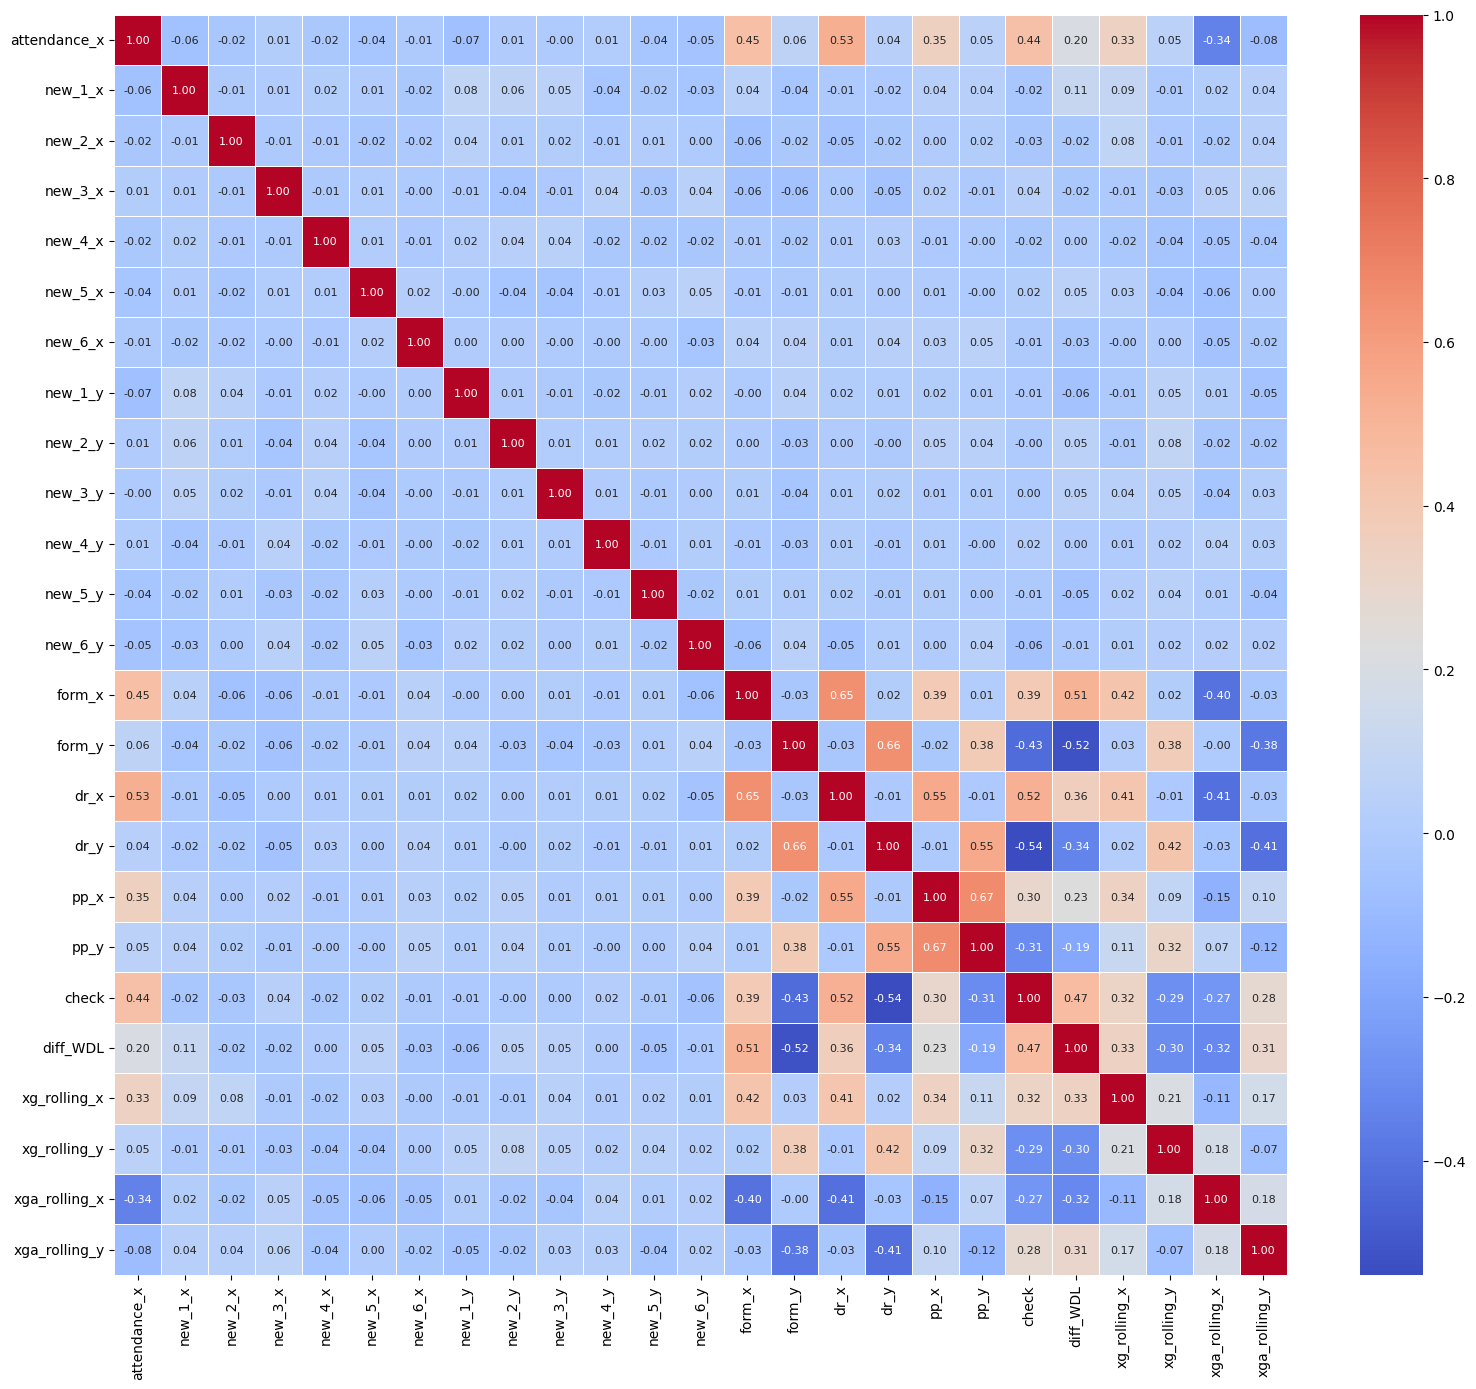

In [39]:
## Let's look at the correlations between the variables. 
# As expected, the predictors resulting from the pca have zero correlation with the other variables. 
# The other variables are correlated with each other, I still leave them as input to the algorithm as they are very significant variables . 
# An improvement can certainly be made in this direction . 

# Selecting columns
selected_df = merged[predictors]
# Calculate the correlation matrix
correlation_matrix = selected_df.corr()

import seaborn as sns
correlation_matrix = selected_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(16, 14))

# Create a heatmap using seaborn with adjusted parameters for better visibility
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 8})

# Show the plot
plt.tight_layout()
plt.show()

In [117]:
## Off topic: how many matches have the following number of goals been recorded? 

occurrences = (merged['gf_x'] + merged['gf_y']).value_counts().reindex(range(11), fill_value=0)
occurrences

0      55
1     172
2     250
3     214
4     150
5      60
6      28
7      18
8       3
9       0
10      1
Name: count, dtype: int64

In [40]:
## TARGET 

merged['target'] = merged['result_x'].apply(lambda x: 1 if x == 'W' else 0)
merged

,team_x,date,time_x,round_x,day_x,venue_x,result_x,gf_x,ga_x,opponent_x,...,form_x,form_y,form_x_next,form_y_next,check,diff_form,diff_dr,diff_WDL,diff_pp,target
0,Internazionale,2021-08-21,18:30,1.0,Sat,Home,W,4.0,0.0,Genoa,...,1.000000,1.000000,1.330000,0.670000,9,0.000000,0,0.0,0,1
1,Empoli,2021-08-21,20:45,1.0,Sat,Home,L,1.0,3.0,Lazio,...,1.000000,1.000000,0.670000,1.330000,-7,0.000000,0,0.0,0,0
2,Hellas Verona,2021-08-21,18:30,1.0,Sat,Home,L,2.0,3.0,Sassuolo,...,1.000000,1.000000,0.670000,1.330000,0,0.000000,0,0.0,0,0
3,Torino,2021-08-21,20:45,1.0,Sat,Home,L,1.0,2.0,Atalanta,...,1.000000,1.000000,0.670000,1.330000,-5,0.000000,0,0.0,0,0
4,Roma,2021-08-22,20:45,1.0,Sun,Home,W,3.0,1.0,Fiorentina,...,1.000000,1.000000,1.330000,0.670000,2,0.000000,0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,Fiorentina,2024-01-14,18:00,20.0,Sun,Home,D,2.0,2.0,Udinese,...,1.276077,0.862836,1.139708,0.999205,4,0.413242,19,2.0,16,0
956,Lazio,2024-01-14,12:30,20.0,Sun,Home,W,1.0,0.0,Lecce,...,1.175127,0.338923,1.286971,0.227078,6,0.836204,8,8.0,9,1
957,Cagliari,2024-01-14,15:00,20.0,Sun,Home,W,2.0,1.0,Bologna,...,0.290793,1.779958,0.878179,1.192572,-3,-1.489165,-21,-2.0,-17,1
958,Milan,2024-01-14,20:45,20.0,Sun,Home,W,3.0,1.0,Roma,...,0.964670,0.871189,1.252163,0.583697,1,0.093481,5,3.0,10,1


In [41]:
## For simplicity's sake, let us divide the database by taking this season's matches as a test set 
## A better analysis can certainly be done by studying the possible combinations of test sets 

train = merged[(merged["date"] < '2023-07-01')]
              
test = merged[(merged["date"] > '2023-07-01')]
             
counts = train['target'].value_counts()
counts

test

,team_x,date,time_x,round_x,day_x,venue_x,result_x,gf_x,ga_x,opponent_x,...,form_x,form_y,form_x_next,form_y_next,check,diff_form,diff_dr,diff_WDL,diff_pp,target
761,Internazionale,2023-08-19,20:45,1.0,Sat,Home,W,2.0,0.0,Monza,...,1.000000,1.000000,1.330000,0.670000,9,0.000000,0,0.0,0,1
762,Frosinone,2023-08-19,18:30,1.0,Sat,Home,L,1.0,3.0,Napoli,...,1.000000,1.000000,0.670000,1.330000,-6,0.000000,0,0.0,0,0
763,Genoa,2023-08-19,20:45,1.0,Sat,Home,L,1.0,4.0,Fiorentina,...,1.000000,1.000000,0.670000,1.330000,-4,0.000000,0,0.0,0,0
764,Empoli,2023-08-19,18:30,1.0,Sat,Home,L,0.0,1.0,Hellas Verona,...,1.000000,1.000000,0.670000,1.330000,-1,0.000000,0,0.0,0,0
765,Udinese,2023-08-20,20:45,1.0,Sun,Home,L,0.0,3.0,Juventus,...,1.000000,1.000000,0.670000,1.330000,-6,0.000000,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,Fiorentina,2024-01-14,18:00,20.0,Sun,Home,D,2.0,2.0,Udinese,...,1.276077,0.862836,1.139708,0.999205,4,0.413242,19,2.0,16,0
956,Lazio,2024-01-14,12:30,20.0,Sun,Home,W,1.0,0.0,Lecce,...,1.175127,0.338923,1.286971,0.227078,6,0.836204,8,8.0,9,1
957,Cagliari,2024-01-14,15:00,20.0,Sun,Home,W,2.0,1.0,Bologna,...,0.290793,1.779958,0.878179,1.192572,-3,-1.489165,-21,-2.0,-17,1
958,Milan,2024-01-14,20:45,20.0,Sun,Home,W,3.0,1.0,Roma,...,0.964670,0.871189,1.252163,0.583697,1,0.093481,5,3.0,10,1


In [42]:
## After analysing the parameters through , I chose the following. A satisfactory but improvable accuracy can be seen

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
                bootstrap=True, 
                max_depth=850,
                max_features='sqrt',
                min_samples_leaf=2,
                min_samples_split=6,
                n_estimators=800,
                random_state=1)

rf.fit(train[predictors], train["target"])

X_test_selected = test[predictors]

y_pred = rf.predict(X_test_selected)

y_pred_proba = rf.predict_proba(X_test_selected)

# MSE e Accuracy
accuracy = accuracy_score(test["target"], y_pred)


accuracy

0.678391959798995

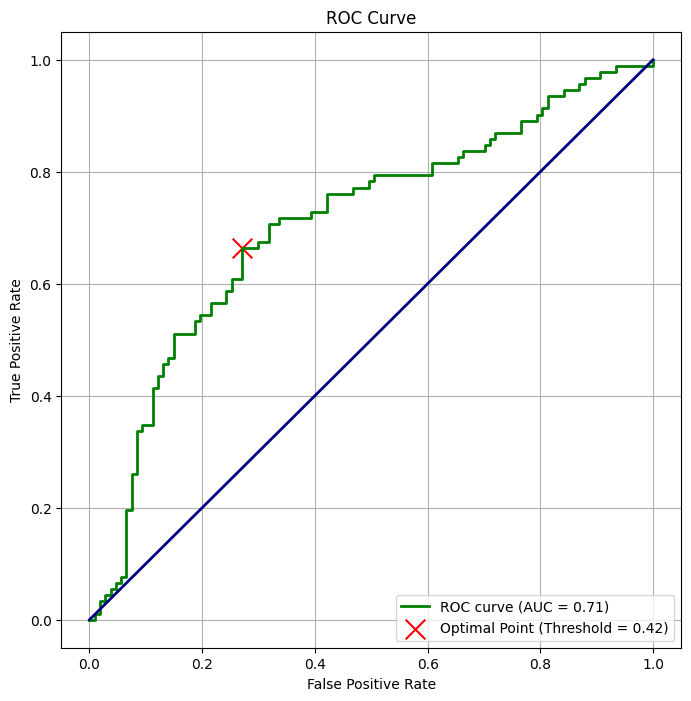

In [55]:
## ROC CURVE ## 


# Assuming test["target"] contains the true labels for the test set
true_labels = test["target"]

# Get predicted probabilities for the positive class (class 1)
y_pred_proba = rf.predict_proba(X_test_selected)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Find the index of the threshold that maximizes sensitivity + specificity
optimal_idx = np.argmax(tpr - fpr)

# Get the optimal threshold
optimal_threshold = thresholds[optimal_idx]

# Plot ROC curve with the optimal point
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', marker='x', s=200, label=f'Optimal Point (Threshold = {optimal_threshold:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()




Accuracy with the new threshold: 0.6834170854271356


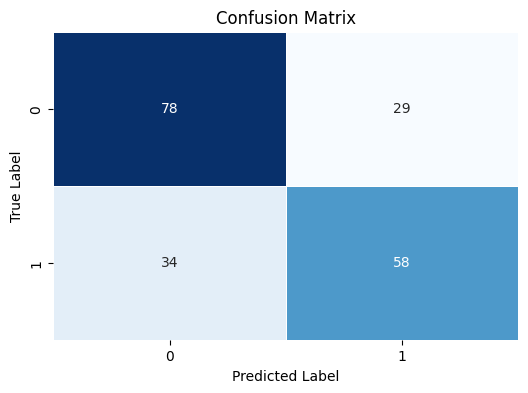

In [66]:
# Get predicted probabilities instead of classes
y_probs = rf.predict_proba(X_test_selected)[:, 1]

# Set the threshold to 0.42
threshold = 0.42

# Classify based on the threshold
y_pred_new_threshold = (y_probs > threshold).astype(int)

# Calculate accuracy with the new threshold
accuracy_new_threshold = accuracy_score(test["target"], y_pred_new_threshold)

# Print Accuracy with the new threshold
print("\nAccuracy with the new threshold:", accuracy_new_threshold)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_new_threshold, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


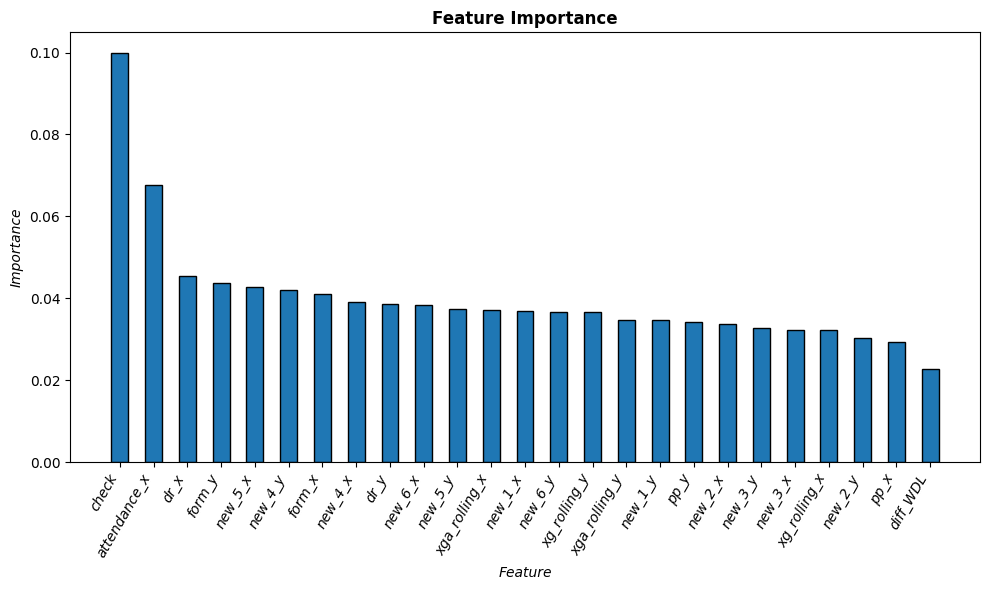

In [79]:
## CURIOSITY : FEATURES IMPORTANCE


# Get feature importances from the model
feature_importances = rf.feature_importances_

# Create a list of tuples with features and their importances
feature_importance_tuples = [(feature, importance) for feature, importance in zip(predictors, feature_importances)]

# Sort the list based on feature importance (from most important to least important)
feature_importance_tuples.sort(key=lambda x: x[1], reverse=True)

# Extract the sorted features and their respective importances
sorted_features, sorted_importances = zip(*feature_importance_tuples)


plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(sorted_features)), sorted_importances, align='center', width=0.5, edgecolor='black')


plt.xticks(range(len(sorted_features)), sorted_features, rotation= 60,  ha='right', fontstyle='italic')
plt.xlabel('Feature', fontstyle='italic')
plt.ylabel('Importance', fontstyle='italic')
plt.title('Feature Importance', fontweight='bold')


plt.tight_layout()
plt.show()